In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gdown
from datetime import datetime


In [2]:
# Download the data
# obs: github não armazena arquivos maiores que 100MB

# df = pd.read_csv('https://raw.githubusercontent.com/andrebrum/andrebrum.github.io/master/datasets/air_quality.csv')
# url = "https://drive.usercontent.google.com/uc?id=1GINDasXHcESqGYMX6KuhEGzCZEx71wHg&confirm=t&authuser=0"
# url = "https://drive.google.com/drive/folders/1faDceV4LIHdOhANpuEgh-9otlMgzy2xP?usp=sharing"

# https://drive.google.com/file/d/1GINDasXHcESqGYMX6KuhEGzCZEx71wHg/view?usp=sharing

ID = "1GINDasXHcESqGYMX6KuhEGzCZEx71wHg"
url = f"https://drive.google.com/uc?id={ID}"
print(url)
gdown.download(url, output="raw_data.zip", quiet=False, use_cookies=True)

# output_zipfile = "raw_data.zip"
# gdown.download(url, output=output_zipfile, quiet=False, use_cookies=True)
# gdown.download_folder(url, output="raw_data", quiet=False, use_cookies=True)

import zipfile
with zipfile.ZipFile("raw_data.zip", 'r') as zip_ref:
    zip_ref.extractall("")




https://drive.google.com/uc?id=1GINDasXHcESqGYMX6KuhEGzCZEx71wHg


Downloading...
From (original): https://drive.google.com/uc?id=1GINDasXHcESqGYMX6KuhEGzCZEx71wHg
From (redirected): https://drive.google.com/uc?id=1GINDasXHcESqGYMX6KuhEGzCZEx71wHg&confirm=t&uuid=79925881-eaec-42dc-bf25-fbed7e00743b
To: /home/adonai/case_elo/raw_data.zip
100%|██████████| 38.3M/38.3M [00:03<00:00, 10.5MB/s]


In [7]:
df_demographic = pd.read_csv('raw_data/DemographicData_ZCTAs.csv', index_col=0)
df_economic = pd.read_csv('raw_data/EconomicData_ZCTAs.csv', index_col=0)

df_geographic = pd.read_csv('raw_data/df_geocode.csv', index_col=0)

df_exams = pd.read_csv('raw_data/exams_data.csv', index_col=0)
df_transactional = pd.read_csv('raw_data/transactional_data.csv', index_col=0, sep=';')

In [10]:
df_transactional[df_transactional['Date of birth'].isnull()]

,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
Patient Id,,,,,,,
7659985004-1,F,NaN,2020-02-22,7659985004-2-1,L152,70000107,"48,0"


In [9]:
df_transactional

,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
Patient Id,,,,,,,
10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70003237,"9,0"
10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000638,"13,0"
10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70001597,"49,0"
10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000103,"11,0"
10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000224,"10,0"
...,...,...,...,...,...,...,...
7664157546-1,M,06/03/1971 00:00:00,2021-02-12,7664157546-1-1,L697,70004038,"10,0"
7664157546-1,M,06/03/1971 00:00:00,2021-02-12,7664157546-1-1,L697,70004134,"10,0"
7664157546-1,M,06/03/1971 00:00:00,2021-02-12,7664157546-1-1,L697,70003056,"9,0"


In [11]:
df_transactional.isnull().sum()

Gender             0
Date of birth      1
Date of service    0
Service Id         0
Lab Id             0
CodItem            0
Testing Cost       0
dtype: int64

In [4]:
df_transactional['Date of birth'] = pd.to_datetime(df_transactional['Date of birth'], errors='coerce')
df_transactional['Date of service'] = pd.to_datetime(df_transactional['Date of service'], errors='coerce')
df_transactional['Date of service'] = df_transactional['Date of service'].dt.strftime('%Y-%m-%d')
df_transactional['Date of Birth'] = df_transactional['Date of birth'].dt.strftime('%Y-%m-%d')
# idade no momento do serviço
# df_transactional['Date of service'] = pd.to_datetime(df_transactional['Date of service'], errors='coerce')
# df_transactional['Date of birth'] = pd.to_datetime(df_transactional['Date of birth'], errors='coerce')

# age at service considering just the year 
df_transactional['age_at_service'] = (pd.to_datetime(df_transactional['Date of service'], errors='coerce').dt.year - pd.to_datetime(df_transactional['Date of birth'], errors='coerce').dt.year).astype(int)


df_transactional['age_at_service']



IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
df_transactional

,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost,Date of Birth,age_at_service
Patient Id,,,,,,,,,
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70003237,"9,0",1976-01-08,43
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000638,"13,0",1976-01-08,43
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70001597,"49,0",1976-01-08,43
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000103,"11,0",1976-01-08,43
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000224,"10,0",1976-01-08,43
...,...,...,...,...,...,...,...,...,...
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70004038,"10,0",1971-06-03,43
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70004134,"10,0",1971-06-03,43
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70003056,"9,0",1971-06-03,43


<Axes: >

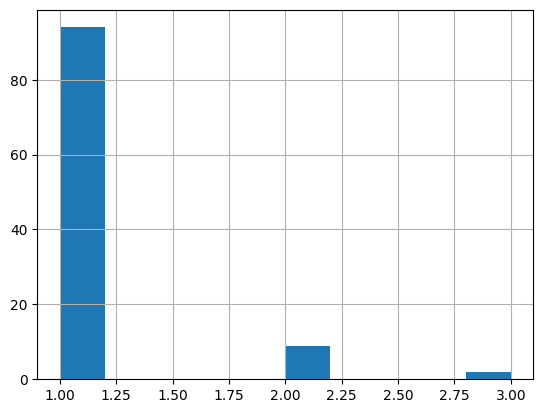

In [5]:
# Contar o número de laboratórios por região (Zipcode)
labs_per_region = geocode.groupby('Zipcode')['Lab Id'].nunique()

# Filtrar regiões com mais de um laboratório
regions_with_multiple_labs = labs_per_region[labs_per_region > 1]

# Exibir as regiões com mais de um laboratório
labs_per_region.hist()

In [27]:
geocode

,Lab Id,Address,Location,Zipcode,ZCTA
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0,ZCTA5 30096
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0,ZCTA5 13440
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0,ZCTA5 98034
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0,ZCTA5 30342
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0,ZCTA5 61469
...,...,...,...,...,...
114,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",8002.0,ZCTA5 08002
115,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421.0,ZCTA5 13421
116,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304.0,ZCTA5 13304
117,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806.0,ZCTA5 52806


In [7]:
demographic[demographic['GeographicAreaName'] == "ZCTA5 30096"]

,Id,GeographicAreaName,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears
5608,8600000US30096,ZCTA5 30096,68691,89.0,4335,4376,4749,4130,4874,11188,9629,10248,4386,3492,4636,1988,660,35.8


In [8]:
geocode

,Lab Id,Address,Location,Zipcode
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0
...,...,...,...,...
114,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",8002.0
115,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421.0
116,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304.0
117,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806.0


In [9]:
from datetime import datetime

# Convert 'Date of birth' to datetime
transactional['Date of birth'] = pd.to_datetime(transactional['Date of birth'], errors='coerce')

# Calculate age
today = datetime.today()
transactional['Age'] = transactional['Date of birth'].apply(lambda dob: today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day)))

# Display the updated DataFrame
transactional[['Date of birth', 'Age']].head()

,Date of birth,Age
Patient Id,,
10210830256-BIO003,1976-01-08,49.0
10210830256-BIO003,1976-01-08,49.0
10210830256-BIO003,1976-01-08,49.0
10210830256-BIO003,1976-01-08,49.0
10210830256-BIO003,1976-01-08,49.0


# Ideias de resolução:

Hipóteses:
- Quero ZCTAs que gerem maior receita. Talvez como segundo critério achar lugares onde o laboratório não está presente para expandir participação no território

- Será que consigo identificar um padrão de quais laboratórios geram maior receita? (desconsiderando outliers)


No cenário de medicina diagnóstica:
- A fidelização é mais importante que a propaganda.


Ideia: 
- fazer algum aprendizado não supervisionado para identificar padrões. 

In [10]:
transactional

,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost,Age
Patient Id,,,,,,,,
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70003237,"9,0",49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000638,"13,0",49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70001597,"49,0",49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000103,"11,0",49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000224,"10,0",49.0
...,...,...,...,...,...,...,...,...
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70004038,"10,0",53.0
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70004134,"10,0",53.0
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70003056,"9,0",53.0


array([[<Axes: title={'center': 'Date of birth'}>,
        <Axes: title={'center': 'CodItem'}>],
       [<Axes: title={'center': 'Age'}>, <Axes: >]], dtype=object)

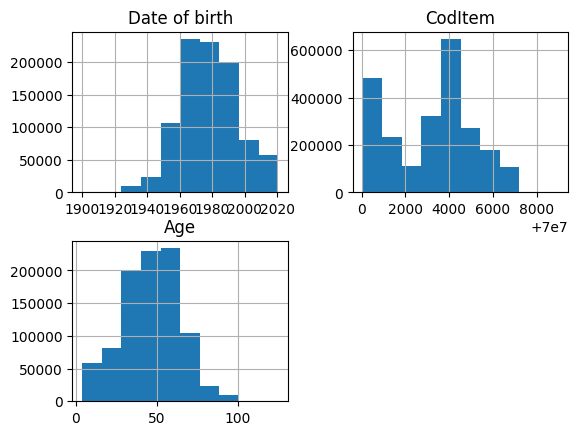

In [11]:
transactional.hist()

In [12]:
# Ensure 'Testing Cost' is numeric
transactional['Testing Cost'] = transactional['Testing Cost'].str.replace(',', '.').astype(float)

# Group by 'Patient Id' and calculate metrics
patient_info = transactional.groupby('Patient Id').agg(
    Number_of_Exams=('CodItem', 'count'),
    Total_Expenditure=('Testing Cost', 'sum'),
    Age=('Age', 'first'),  # Assuming age is consistent for each patient
    Gender=('Gender', 'first')  # Assuming gender is consistent for each patient
).reset_index()

# Display the resulting DataFrame
patient_info

,Patient Id,Number_of_Exams,Total_Expenditure,Age,Gender
0,-2,10,204.00,125.0,I
1,1000007167-1,1,12.00,61.0,F
2,1000007439-1,4,52.00,28.0,F
3,1000014746-1,17,470.00,NaN,M
4,1000025251-1,1,113.00,NaN,F
...,...,...,...,...,...
501441,99958237-BIO003,9,164.00,53.0,M
501442,99974240-BIO010,9,270.00,65.0,F
501443,99999-1,35,4394.00,75.0,M
501444,999999-1,17,8204.00,75.0,F


In [13]:
patient_info

,Patient Id,Number_of_Exams,Total_Expenditure,Age,Gender
0,-2,10,204.00,125.0,I
1,1000007167-1,1,12.00,61.0,F
2,1000007439-1,4,52.00,28.0,F
3,1000014746-1,17,470.00,NaN,M
4,1000025251-1,1,113.00,NaN,F
...,...,...,...,...,...
501441,99958237-BIO003,9,164.00,53.0,M
501442,99974240-BIO010,9,270.00,65.0,F
501443,99999-1,35,4394.00,75.0,M
501444,999999-1,17,8204.00,75.0,F


In [14]:
economic

,id,Geographic Area Name,TotalHouseholds_LessThan$10.000,TotalHouseholds_$10.000to$14.999,TotalHouseholds_$15.000to$24.999,TotalHouseholds_$25.000to$34.999,TotalHouseholds_$35.000to$49.999,TotalHouseholds_$50.000to$74.999,TotalHouseholds_$75.000to$99.999,TotalHouseholds_$100.000to$149.999,TotalHouseholds_$150.000to$199.999,TotalHouseholds_$200.000OrMore
0,8600000US35004,ZCTA5 35004,198,71,298,513,647,1117,529,945,245,61
1,8600000US35005,ZCTA5 35005,188,184,318,293,353,562,299,407,67,26
2,8600000US35006,ZCTA5 35006,71,20,117,104,154,176,124,194,51,7
3,8600000US35007,ZCTA5 35007,396,208,670,462,1173,1854,1578,2224,473,254
4,8600000US35010,ZCTA5 35010,700,610,1093,957,1056,1512,807,749,254,249
...,...,...,...,...,...,...,...,...,...,...,...,...
629275,8600000US00979,ZCTA5 00979,735,471,1547,1374,957,1390,662,643,99,319
629276,8600000US00982,ZCTA5 00982,1299,483,1184,848,1104,657,206,79,34,16
629277,8600000US00983,ZCTA5 00983,2638,1368,2495,1845,1906,1952,511,363,110,96
629278,8600000US00985,ZCTA5 00985,2426,1150,2266,1777,1873,1737,501,395,15,26


# Data Cleaning

geocode

In [15]:
# geocode[geocode['Zipcode'].isna()]
geocode = geocode.dropna(subset=['Zipcode'])

In [16]:
geocode["ZCTA"] = geocode["Zipcode"].apply(lambda x: f"ZCTA5 {int(x):05d}" if pd.notna(x) else x)
# Transformando o Zipcode para o mesmo formato do DemographicData_ZCTAs
# ignora os valores nulos pois não adicionam informação


/tmp/ipykernel_34322/316764163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geocode["ZCTA"] = geocode["Zipcode"].apply(lambda x: f"ZCTA5 {int(x):05d}" if pd.notna(x) else x)


In [17]:
geocode

,Lab Id,Address,Location,Zipcode,ZCTA
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0,ZCTA5 30096
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0,ZCTA5 13440
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0,ZCTA5 98034
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0,ZCTA5 30342
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0,ZCTA5 61469
...,...,...,...,...,...
114,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",8002.0,ZCTA5 08002
115,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421.0,ZCTA5 13421
116,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304.0,ZCTA5 13304
117,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806.0,ZCTA5 52806


In [18]:
transactional[transactional['Date of birth'].isnull()]
# Apenas um valor nulo no dataset todo, que pode gerar algum problema. Arranca fora
transactional = transactional.dropna(subset=['Date of birth'])

In [19]:
exams

,Desc Item,Category,Family,Speciality,Testing Cost
CodItem,,,,,
70003237,"MAGNESIO, SORO (EXEMPLO DE EXPRESSAO DE RESULT...",CA,CORELAB,BIOCHEMISTRY,1.78
70000638,"HEMOGRAMA, AUTOMATIZADO, SANGUE",CA,HEMATO,BLOOD COUNT,2.46
70001597,"FERRITINA, SORO",CA,CORELAB,IMMUNOHORMONE,2.11
70000103,"FERRO, DOSAGEM, SORO (EXEMPLO DE EXPRESSAO DE ...",CA,CORELAB,BIOCHEMISTRY,0.80
70000224,"CALCIO, DOSAGEM, SORO (EXEMPLO DE EXPRESSAO DE...",CA,CORELAB,BIOCHEMISTRY,1.02
...,...,...,...,...,...
70008635,"GENES BRCA1 E BRCA2, MLPA, SANGUE",CA,GENETICS,SPECIAL GENETICS,159.91
70005303,"OBSTETRICA 1§ TRIMESTRE (ENDOVAGINAL), SEGUNDO...",RID,ULTRASOUND,FETAL MEDICINE,111.43
70006441,"HEMOFILIA A, ANALISE DO DNA, SEQUENCIAMENTO, S...",CA,GENETICS,SPECIAL GENETICS,27.03


In [20]:
transactional

,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost,Age
Patient Id,,,,,,,,
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70003237,9.0,49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000638,13.0,49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70001597,49.0,49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000103,11.0,49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000224,10.0,49.0
...,...,...,...,...,...,...,...,...
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70004038,10.0,53.0
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70004134,10.0,53.0
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70003056,9.0,53.0


In [21]:
transactional['is_male'] = transactional['Gender'].apply(lambda x: 1 if x == 'M' else 0)

/tmp/ipykernel_34322/198439067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactional['is_male'] = transactional['Gender'].apply(lambda x: 1 if x == 'M' else 0)


In [22]:
# Convert 'Date of birth' to datetime
transactional['Date of birth'] = pd.to_datetime(transactional['Date of birth'], errors='coerce')

# Calculate age
today = datetime.today()
transactional['age'] = transactional['Date of birth'].apply(lambda dob: today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day)))


/tmp/ipykernel_34322/653504229.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactional['Date of birth'] = pd.to_datetime(transactional['Date of birth'], errors='coerce')
/tmp/ipykernel_34322/653504229.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactional['age'] = transactional['Date of birth'].apply(lambda dob: today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day)))


In [23]:
patient_info = transactional.groupby('Patient Id').agg(
    number_of_exams=('CodItem', 'count'),
    total_expenditure=('Testing Cost', 'sum'),
    age=('age', 'first'),  # Assuming age is consistent for each patient
    is_male=('is_male', 'first')  # Assuming gender is consistent for each patient
).reset_index()

array([[<Axes: title={'center': 'number_of_exams'}>,
        <Axes: title={'center': 'total_expenditure'}>],
       [<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'is_male'}>]], dtype=object)

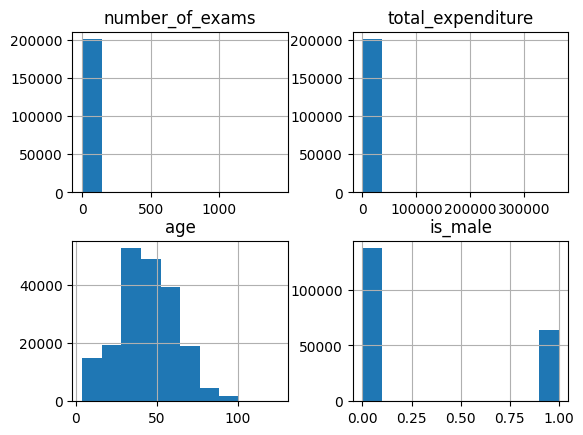

In [24]:
patient_info.hist()

In [25]:
patient_info

,Patient Id,number_of_exams,total_expenditure,age,is_male
0,-2,10,204.00,125,0
1,1000007167-1,1,12.00,61,0
2,1000007439-1,4,52.00,28,0
3,1000029030-1,1,76.00,53,0
4,1000031124-1,2,27.00,19,1
...,...,...,...,...,...
200849,99958237-BIO003,9,164.00,53,1
200850,99974240-BIO010,9,270.00,65,0
200851,99999-1,35,4394.00,75,1
200852,999999-1,17,8204.00,75,0


In [ ]:
# lab_info = transactional.groupby('Lab Id').agg()

TypeError: Must provide 'func' or tuples of '(column, aggfunc).